In [110]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, ElasticNetCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

stop_words = set(stopwords.words('spanish'))  # Definir stop_words en español
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eslab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
df = pd.read_csv('data/fake_news_clean.csv')

### 1. Carga y Filtrado de Datos
#### Cargamos los datos de noticias y filtramos las clases que tienen un número mínimo de muestras para un mejor entrenamiento.

In [36]:
min_samples_threshold = 10
source_counts = df['Source'].value_counts()
sources_to_keep = source_counts[source_counts >= min_samples_threshold].index

# Agrupar fuentes raras en "Otros"
#df['Source'] = df['Source'].apply(lambda x: x if x in sources_to_keep else "Otros")

### 2. División de Datos y Vectorización
#### En esta sección, dividimos los datos en conjunto de entrenamiento y prueba. Luego, utilizamos `TfidfVectorizer` para convertir el texto en una matriz de características.

In [37]:
# División de datos de entrenamiento y prueba
X = df['Text']
y = df['Source']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [38]:
# Vectorización del texto utilizando TF-IDF
# Convertir el conjunto de stopwords a una lista
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), stop_words=list(stop_words))

# Transformar los datos de entrenamiento y prueba
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [40]:
# Asegurarse de que las etiquetas son cadenas de texto
y_train = y_train.astype(str)

# Filtrado de clases pequeñas
unique_classes, counts = np.unique(y_train, return_counts=True)

# Crear un DataFrame para visualizar la distribución de clases
class_distribution = pd.DataFrame({'Class': unique_classes, 'Count': counts})

# Definir un umbral mínimo para el número de muestras por clase
min_samples_threshold = 10

# Mantener solo las clases que tienen suficientes muestras
classes_to_keep = class_distribution[class_distribution['Count'] >= min_samples_threshold]['Class'].tolist()

# Filtrar las etiquetas y los datos vectorizados de entrenamiento
y_train_filtered = y_train[y_train.isin(classes_to_keep)]
X_train_filtered = X_train_vec[y_train.isin(classes_to_keep)]

### 3. Balanceo de Clases con SMOTE
#### Para solucionar el desbalance de clases, aplicamos SMOTE (Synthetic Minority Over-sampling Technique) en el conjunto de entrenamiento.

In [41]:
# Resampling con SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

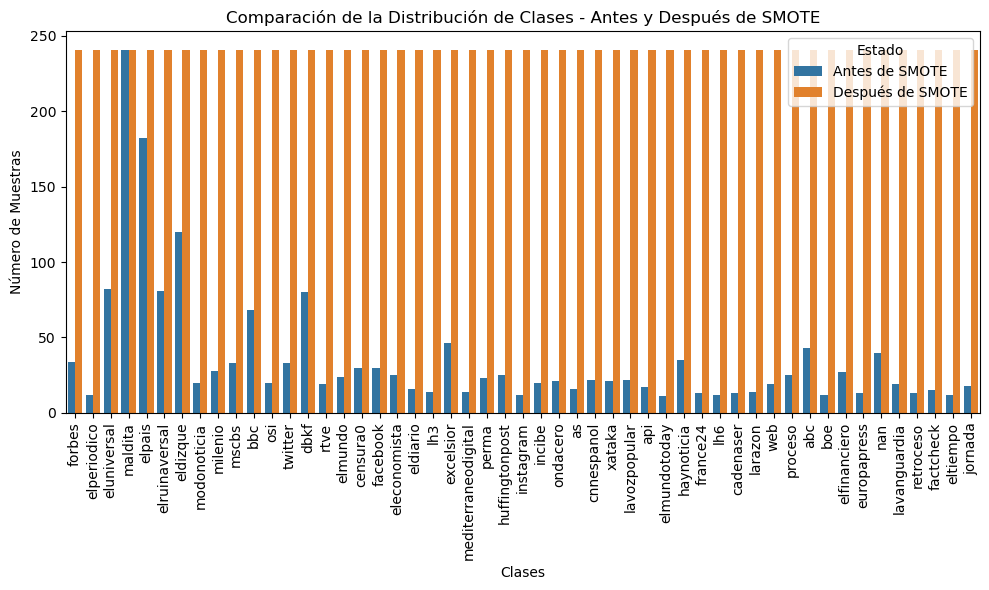

In [42]:
# Distribución de clases antes de aplicar SMOTE
class_distribution_before = pd.DataFrame(Counter(y_train_filtered).items(), columns=['Class', 'Count'])
class_distribution_before['Type'] = 'Antes de SMOTE'

# Distribución de clases después de aplicar SMOTE
class_distribution_after = pd.DataFrame(Counter(y_train_resampled).items(), columns=['Class', 'Count'])
class_distribution_after['Type'] = 'Después de SMOTE'

# Combinar ambos DataFrames
class_distribution_combined = pd.concat([class_distribution_before, class_distribution_after])

# Gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', hue='Type', data=class_distribution_combined)
plt.title('Comparación de la Distribución de Clases - Antes y Después de SMOTE')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.xticks(rotation=90)  # Rotar las etiquetas de las clases si es necesario
plt.legend(title='Estado')
plt.tight_layout()
plt.show()

#### Entrenamiento del Modelo y Búsqueda de Hiperparámetros
Entrenamos un modelo `RandomForest` y realizamos una búsqueda de hiperparámetros utilizando `GridSearchCV` para encontrar los mejores parámetros del modelo.

In [49]:
# Ajuste de hiperparámetros con GridSearchCV para RandomForest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [55]:
# Clasificadores: Logistic Regression, Ridge, Random Forest, SVM
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

In [56]:
# Entrenar los modelos y generar predicciones
predictions = {}
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    predictions[name] = clf.predict(X_test_vec)

In [61]:
# Reportes de clasificación para cada modelo
for name, preds in predictions.items():
    preds = preds.astype(str)  # Asegúrate de que las predicciones son de tipo str
    y_test_array = y_test.to_numpy().astype(str)  # Convierte y_test a un arreglo de NumPy de tipo str
    print(f"\n{name} Report:")
    print(classification_report(y_test_array, preds))


Logistic Regression Report:
                         precision    recall  f1-score   support

              12minutos       0.00      0.00      0.00         1
               2020news       0.00      0.00      0.00         1
              20minutos       0.00      0.00      0.00         1
Noticiadelsoldelalaguna       0.00      0.00      0.00         2
             Noticiarcn       0.00      0.00      0.00         1
                    abc       0.31      0.44      0.36         9
            aboutamazon       0.00      0.00      0.00         1
                   aepd       0.00      0.00      0.00         1
      agenciatributaria       0.00      0.00      0.00         1
          alertadigital       0.00      0.00      0.00         3
                    api       0.00      0.00      0.00         2
          aragondigital       0.00      0.00      0.00         1
               aranjuez       0.00      0.00      0.00         1
                archive       0.00      0.00      0.00      

c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

In [70]:


# Codificar las etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)

# Clasificadores
classifiers = {
    "Logistic Regression (L2)": LogisticRegression(penalty='l2', C=1.0),
    "Ridge Classifier": RidgeClassifier(alpha=1.0),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')  # Asegúrate de que XGBoost esté importado
}


In [71]:
# Entrenar modelos y generar predicciones
predictions = {}
for name, clf in classifiers.items():
    if name == "XGBoost":
        clf.fit(X_train_resampled, y_train_encoded)  # Usar etiquetas codificadas para XGBoost
    else:
        clf.fit(X_train_resampled, y_train_resampled)  # Usar etiquetas originales para los demás clasificadores

    preds = clf.predict(X_test_vec)

    # Si es XGBoost, transforma las predicciones de nuevo a las etiquetas originales
    if name == "XGBoost":
        preds = label_encoder.inverse_transform(preds)

    predictions[name] = preds

# Reportes de clasificación
for name, preds in predictions.items():
    preds = preds.astype(str)  # Asegúrate de que las predicciones son de tipo str
    y_test_array = y_test.to_numpy().astype(str)  # Convierte y_test a un arreglo de NumPy de tipo str
    print(f"\n{name} Report:")
    print(classification_report(y_test_array, preds))


Logistic Regression (L2) Report:
                         precision    recall  f1-score   support

              12minutos       0.00      0.00      0.00         1
               2020news       0.00      0.00      0.00         1
              20minutos       0.00      0.00      0.00         1
Noticiadelsoldelalaguna       0.00      0.00      0.00         2
             Noticiarcn       0.00      0.00      0.00         1
                    abc       0.31      0.44      0.36         9
            aboutamazon       0.00      0.00      0.00         1
                   aepd       0.00      0.00      0.00         1
      agenciatributaria       0.00      0.00      0.00         1
          alertadigital       0.00      0.00      0.00         3
                    api       0.00      0.00      0.00         2
          aragondigital       0.00      0.00      0.00         1
               aranjuez       0.00      0.00      0.00         1
                archive       0.00      0.00      0.00 

c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res

                         precision    recall  f1-score   support

              12minutos       0.00      0.00      0.00         1
               2020news       0.00      0.00      0.00         1
              20minutos       0.00      0.00      0.00         1
Noticiadelsoldelalaguna       0.00      0.00      0.00         2
             Noticiarcn       0.00      0.00      0.00         1
                    abc       1.00      0.44      0.62         9
            aboutamazon       0.00      0.00      0.00         1
                   aepd       0.00      0.00      0.00         1
      agenciatributaria       0.00      0.00      0.00         1
          alertadigital       0.00      0.00      0.00         3
                    api       0.00      0.00      0.00         2
          aragondigital       0.00      0.00      0.00         1
               aranjuez       0.00      0.00      0.00         1
                archive       0.00      0.00      0.00         1
      argumentopolitico 

c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

#### Creación de un Modelo de Ensemble
Creamos un modelo ensemble utilizando `VotingClassifier`.


In [89]:


# Definir el modelo de XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Crear el modelo de ensemble
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)],
    voting='soft')  # 'soft' usa promedios de probabilidades

# Ajustar el modelo de ensemble
ensemble_model.fit(X_train_resampled, y_train_resampled)

# Predecir con el conjunto de prueba
y_pred = ensemble_model.predict(X_test_vec)

# Asegúrate de que tanto y_test como y_pred son del mismo tipo
y_test_str = y_test.astype(str)  # Convertir y_test a str
y_pred_str = y_pred.astype(str)  # Convertir y_pred a str

# Evaluar el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test_str, y_pred_str))
print("\nInforme de clasificación:")
print(classification_report(y_test_str, y_pred_str))

# Ajuste de hiperparámetros con GridSearchCV para RandomForest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Mostrar los mejores parámetros y la puntuación
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)
print("Mejor puntuación para Random Forest:", grid_search_rf.best_score_)
# Asegurarse de que y_pred y y_test son del mismo tipo
y_pred = y_pred.astype(str)  # Convertir y_pred a str
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\xgboost\core.py:158: UserWarning: [16:19:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Matriz de confusión:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]]

Informe de clasificación:
                         precision    recall  f1-score   support

              12minutos       0.00      0.00      0.00         1
               2020news       0.00      0.00      0.00         1
              20minutos       0.00      0.00      0.00         1
Noticiadelsoldelalaguna       0.00      0.00      0.00         2
             Noticiarcn       0.00      0.00      0.00         1
                    abc       0.33      0.44      0.38         9
            aboutamazon       0.00      0.00      0.00         1
                   aepd       0.00      0.00      0.00         1
      agenciatributaria       0.00      0.00      0.00         1
          alertadigital       0.00      0.00      0.00         3
                    api       0.00      0.00      0.00         2
          aragondigital       0.00      0.00      0

c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

Mejores parámetros para Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Mejor puntuación para Random Forest: 0.9190542306354731

Informe de clasificación:


TypeError: '<' not supported between instances of 'float' and 'str'

In [92]:
# Vectorización del texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), stop_words=list(stop_words))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [93]:
# Preprocesamiento de etiquetas
y_train = y_train.astype(str)
unique_classes, counts = np.unique(y_train, return_counts=True)
class_distribution = pd.DataFrame({'Class': unique_classes, 'Count': counts})

In [94]:
classes_to_keep = class_distribution[class_distribution['Count'] >= min_samples_threshold]['Class'].tolist()
y_train_filtered = y_train[y_train.isin(classes_to_keep)]
X_train_filtered = X_train_vec[y_train.isin(classes_to_keep)]

In [95]:
# Resampling con SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

 Usamos `TruncatedSVD` para reducir la dimensionalidad de los datos, lo cual ayuda a disminuir el tiempo de entrenamiento y mejorar el rendimiento del modelo.

In [98]:
# TruncatedSVD para reducción de dimensionalidad
svd = TruncatedSVD(n_components=100, random_state=42)  # Ajustar el número de componentes deseado
X_train_svd = svd.fit_transform(X_train_resampled)
X_test_svd = svd.transform(X_test_vec)

In [99]:
# Modelos de clasificadores
classifiers = {
    "Logistic Regression (L2)": LogisticRegression(penalty='l2', C=1.0, max_iter=1000),
    "Ridge Classifier": RidgeClassifier(alpha=1.0),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', C=1.0),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}

In [113]:
classifiers = {


    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SGD Classifier": SGDClassifier(),
    "ElasticNet": ElasticNetCV(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": MultinomialNB(),
    "MLP Classifier": MLPClassifier(max_iter=500),
    "Gaussian Naive Bayes": GaussianNB()
}

In [114]:

# Codificación de etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)

In [115]:
# Entrenamiento de modelos y predicción
predictions = {}
for name, clf in classifiers.items():
    if name == "XGBoost":
        clf.fit(X_train_svd, y_train_encoded)
        preds = clf.predict(X_test_svd)
        preds = label_encoder.inverse_transform(preds)
    else:
        clf.fit(X_train_svd, y_train_resampled)
        preds = clf.predict(X_test_svd)
    predictions[name] = preds

c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


ValueError: could not convert string to float: 'censura0'

In [ ]:
# Informe de clasificación
for name, preds in predictions.items():
    y_test_str = y_test.astype(str)
    preds_str = preds.astype(str)
    print(f"\n{name} Report:")
    print(classification_report(y_test_str, preds_str, zero_division=0))


Gradient Boosting Report:
                     precision    recall  f1-score   support

                abc       0.00      0.00      0.00         4
                api       0.00      0.00      0.00         4
  argumentopolitico       0.00      0.00      0.00         4
                 as       0.00      0.00      0.00         2
                bbc       0.55      0.43      0.48        14
                boe       0.00      0.00      0.00         2
          cadenaser       0.00      0.00      0.00         1
           censura0       1.00      0.14      0.25         7
         cnnespanol       0.00      0.00      0.00         5
          comunidad       0.50      0.50      0.50         2
               dbkf       0.15      0.36      0.22        11
       diariodeleon       1.00      0.50      0.67         2
     elconfidencial       0.00      0.00      0.00         1
           eldiario       0.00      0.00      0.00         4
           eldizque       0.33      0.57      0.42       

In [102]:
# Informe de clasificación
for name, preds in predictions.items():
    y_test_str = y_test.astype(str)
    preds_str = preds.astype(str)
    print(f"\n{name} Report:")
    print(classification_report(y_test_str, preds_str, zero_division=0))


Logistic Regression (L2) Report:
                         precision    recall  f1-score   support

              12minutos       0.00      0.00      0.00         1
               2020news       0.00      0.00      0.00         1
              20minutos       0.00      0.00      0.00         1
Noticiadelsoldelalaguna       0.00      0.00      0.00         2
             Noticiarcn       0.00      0.00      0.00         1
                    abc       0.13      0.44      0.20         9
            aboutamazon       0.00      0.00      0.00         1
                   aepd       0.00      0.00      0.00         1
      agenciatributaria       0.00      0.00      0.00         1
          alertadigital       0.00      0.00      0.00         3
                    api       0.00      0.00      0.00         2
          aragondigital       0.00      0.00      0.00         1
               aranjuez       0.00      0.00      0.00         1
                archive       0.00      0.00      0.00 

In [103]:
# Modelo de Voting Ensemble
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss', use_label_encoder=False)
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')

In [104]:

ensemble_model.fit(X_train_svd, y_train_encoded if isinstance(ensemble_model, XGBClassifier) else y_train_resampled)
y_pred = ensemble_model.predict(X_test_svd)

c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [105]:
# Inversión de codificación si es XGBoost
if isinstance(ensemble_model, XGBClassifier):
    y_pred = label_encoder.inverse_transform(y_pred)
print("\nVoting Ensemble Report:")
print(classification_report(y_test.astype(str), y_pred.astype(str), zero_division=0))


Voting Ensemble Report:
                         precision    recall  f1-score   support

              12minutos       0.00      0.00      0.00         1
               2020news       0.00      0.00      0.00         1
              20minutos       0.00      0.00      0.00         1
Noticiadelsoldelalaguna       0.00      0.00      0.00         2
             Noticiarcn       0.00      0.00      0.00         1
                    abc       0.22      0.44      0.30         9
            aboutamazon       0.00      0.00      0.00         1
                   aepd       0.00      0.00      0.00         1
      agenciatributaria       0.00      0.00      0.00         1
          alertadigital       0.00      0.00      0.00         3
                    api       0.00      0.00      0.00         2
          aragondigital       0.00      0.00      0.00         1
               aranjuez       0.00      0.00      0.00         1
                archive       0.00      0.00      0.00         1

In [91]:
# Vectorizing the text data
tfidf = TfidfVectorizer()

# Fit and transform the train data, and transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
}

# Create the RandomForest model
rf = RandomForestClassifier(class_weight='balanced')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the model using the transformed data
grid_search.fit(X_train_tfidf, y_train)

# Best parameters and score
print("Best parameters for Random Forest:", grid_search.best_params_)
print("Best score for Random Forest:", grid_search.best_score_)

# Predictions and classification report
y_pred = grid_search.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, zero_division=0))

c:\Users\eslab\anaconda3\envs\verifake_env\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best score for Random Forest: 0.08808184533302828


TypeError: '<' not supported between instances of 'float' and 'str'

In [108]:
# Leer datos
df = pd.read_csv('data/fake_news_clean.csv')

# Convertir etiquetas a string
df['Source'] = df['Source'].astype(str)

# Filtrar clases con un número suficiente de muestras
min_samples_threshold = 10
df_filtered = df.groupby('Source').filter(lambda x: len(x) >= min_samples_threshold)

# Re-definir X e y después del filtrado
X = df_filtered['Text']
y = df_filtered['Source']

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Vectorización del texto usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3), stop_words=list(stop_words))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Aplicar SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vec, y_train)
print(f"Dimensiones después de SMOTE: {X_train_resampled.shape}, {len(y_train_resampled)}")

# TruncatedSVD para reducción de dimensionalidad
svd = TruncatedSVD(n_components=150, random_state=42)
X_train_svd = svd.fit_transform(X_train_resampled)
X_test_svd = svd.transform(X_test_vec)

# Codificación de etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)

# Verificación final de dimensiones
print(f"Dimensiones finales: X_train_svd = {X_train_svd.shape}, y_train_encoded = {len(y_train_encoded)}")

# Continúa con el entrenamiento del modelo
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train_svd, y_train_encoded)



Dimensiones después de SMOTE: (14322, 5000), 14322
Dimensiones finales: X_train_svd = (14322, 150), y_train_encoded = 14322


MemoryError: Unable to allocate 5.46 MiB for an array with shape (4774, 150) and data type float64